In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
# read in data
filename1 = 'everest_for_env_lift_analysis.csv'
filename2 = 'everest_for_env_lift_analysis.csv'
filename3 = 'everest_for_env_lift_analysis.csv'

envds = pd.read_csv(filename1)
envds['dummy'] = 1
print(envds.columns)
#print(envds.head())

#symds = pd.read_csv(filename2)
#symds['dummy'] = 1
#print(symds.columns)
#print(symds.head())

#ocpds = pd.read_csv(filename3)
#ocpds['dummy'] = 1
#print(ocpds.columns)
#print(ocpds.head())

Index(['record_id', 'py', 'state', 'ZIP', 'LIAB_PREM', 'COLL_PREM', 'OTC_PREM',
       'PHYSDAM_PREM', 'TOTAL_PREM', 'LIAB_LOSS', 'COLL_LOSS', 'OTC_LOSS',
       'PHYSDAM_LOSS', 'TOTAL_LOSS', 'LIAB_EXP', 'COLL_EXP', 'OTC_EXP',
       'PHYSDAM_EXP', 'TOTAL_EXP', 'LIAB_CNT', 'COLL_CNT', 'OTC_CNT',
       'PHYSDAM_CNT', 'TOTAL_CNT', 'LIAB_LOSS99', 'LIAB_LOSS995', 'OTC_LOSS99',
       'OTC_LOSS995', 'COLL_LOSS99', 'COLL_LOSS995', 'TOTAL_LOSS995',
       'TOTAL_LOSS99', 'PHYSDAM_LOSS995', 'PHYSDAM_LOSS99', 'liab_ratio',
       'coll_ratio', 'otc_ratio', 'VehicleType', 'LIAB_OFFBAL', 'COLL_OFFBAL',
       'OTC_OFFBAL', 'coll_newprem', 'OTC_newprem', 'liab_newprem', 'LIAB_BAL',
       'COLL_BAL', 'OTC_BAL', 'PHYSDAM_NEWPREM', 'TOTAL_NEWPREM', 'dummy'],
      dtype='object')


In [118]:
def lift(ods, sample, newrel, prem, loss, bars):
    # rename columns without modifying original file
    ds = ods.rename(columns={newrel : 'newrel', 
                             prem : 'prem1', 
                             loss : 'loss1'
                             #'expo1': 'expo1',
                             #'claim1': 'claim1
                            })

    # filter for positive newrel records
    ds = ds.loc[(ds['newrel'] > 0) & (ds['prem1'] > 0)]

    # sort by sample and newrel
    ds = ds.sort_values(by=[sample, 'newrel'])
    ds = ds.reset_index(drop=True)

    # get premium percentile, group into desired number of buckets
    ds['prem2'] = ds['prem1'] * ds['newrel']
    ds['prem1_perctl'] = ds.groupby(sample).prem1.cumsum() / ds.groupby(sample).prem1.transform('sum')
    ds['bars'] = bars
    ds['bar'] = np.ceil(ds['bars'] * ds['prem1_perctl']) / ds['bars']

    # offbalance by sample
    ds['prem2_ob'] = round(
        ds['prem2'] * (ds.groupby(sample).prem1.transform('sum') / 
                ds.groupby(sample).prem2.transform('sum')), 2)

    # re-index average LR to 1.0
    ds['loss2'] = ds['loss1'] / (ds['loss1'].sum() / ds['prem1'].sum())
    #print(ds)

    # write out ds
    #ds.to_csv('out1.csv')

    # summary dataframe
    summ_ds = pd.DataFrame()
    summ_ds['loss_re'] = ds.groupby('bar').loss2.sum()
    summ_ds['loss_ori'] = ds.groupby('bar').loss1.sum()
    summ_ds['current_prem'] = ds.groupby('bar').prem1.sum()
    summ_ds['current_LR'] = summ_ds['loss_re'] / summ_ds['current_prem']
    summ_ds['new_prem'] = ds.groupby('bar').prem2_ob.sum()
    summ_ds['new_LR'] = summ_ds['loss_re'] / summ_ds['new_prem'] 
    summ_ds['bars'] = summ_ds.index
    
    print(summ_ds)
    
    # create new dataframe for charting
    pd.options.mode.chained_assignment = None
    plot_ds = pd.DataFrame()
    #ser1 = summ_ds.iloc[:,3]
    #ser2 = summ_ds.iloc[:,5]
    ser1 = summ_ds.current_LR
    ser2 = summ_ds.new_LR 
    plot_ds['y'] = pd.concat([ser1, ser2])
    plot_ds['hue'] = 'dummy'
    plot_ds['hue'].iloc[:len(ser1)] = 'Current'
    plot_ds['hue'].iloc[len(ser1):] = 'New'
    plot_ds['bars'] = plot_ds.index
    
    print(plot_ds)

    # create lift charts
    #plt.bar(plot_ds['bars'], plot_ds['current_LR'], color='blue')
    #plt.bar(plot_ds['bars'], plot_ds['new_LR'], color='pink')
    #plt.show()
    g = sns.catplot(x="bars", y="y", hue="hue", data=plot_ds,
                height=5, kind="bar", palette="muted", )
    g.despine(left=True)
    g.set(ylim=(0, 1.5))
    g.set_xlabels("Premium Quantile")
    g.set_ylabels("Loss Ratio")

          loss_re     loss_ori  current_prem  current_LR     new_prem  \
bar                                                                     
0.2  1.213852e+07   5662650.67  2.539512e+07    0.477986  15755843.98   
0.4  2.386422e+07  11132721.69  2.539612e+07    0.939680  20252142.60   
0.6  2.728075e+07  12726540.79  2.539588e+07    1.074220  24656536.12   
0.8  3.135665e+07  14627957.88  2.539543e+07    1.234736  29814918.63   
1.0  3.234013e+07  15086755.65  2.539773e+07    1.273347  36500839.91   

       new_LR  bars  
bar                  
0.2  0.770414   0.2  
0.4  1.178355   0.4  
0.6  1.106431   0.6  
0.8  1.051710   0.8  
1.0  0.886011   1.0  
            y      hue  bars
bar                         
0.2  0.477986  Current   0.2
0.4  0.939680  Current   0.4
0.6  1.074220  Current   0.6
0.8  1.234736  Current   0.8
1.0  1.273347  Current   1.0
0.2  0.770414      New   0.2
0.4  1.178355      New   0.4
0.6  1.106431      New   0.6
0.8  1.051710      New   0.8
1.0  0.886011  

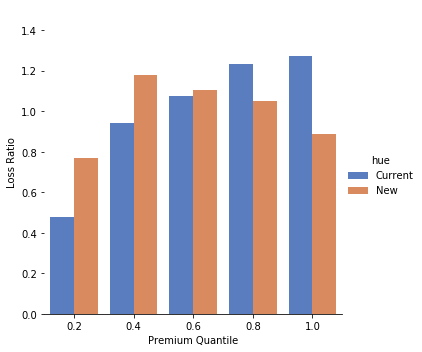

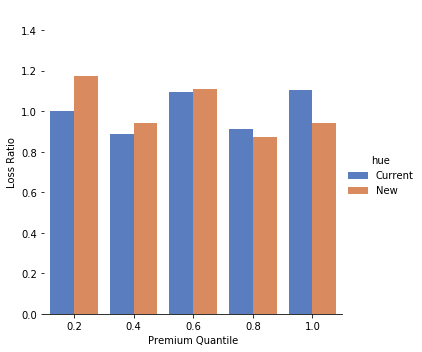

In [119]:
#lift(envds, 'dummy', 'liab_ratio', 'LIAB_PREM', 'LIAB_LOSS99', 5)
#lift(envds, 'dummy', 'coll_ratio', 'COLL_PREM', 'COLL_LOSS99', 5)
lift(envds, 'VehicleType', 'liab_ratio', 'LIAB_PREM', 'LIAB_LOSS99', 5)
lift(envds, 'VehicleType', 'coll_ratio', 'COLL_PREM', 'COLL_LOSS99', 5)